In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from joblib import Parallel

from useful_func import *


from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion


import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

import click

from alienlab.plot import PlotFigure
p = PlotFigure()
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"
p.extension = ".pdf"

#%matplotlib widget

In [2]:
folder= "../data/macroimager/"
list_names = ["fps5_blue4_60pm", "fps4_blue4_60pm_2", "fps2_blue5_60pm_1led_expo500ms_cuve", "fps2_blue5_60pm_1led_expo500ms_petri35mm", "fps2_blue5_60pm_1over2led_expo400ms_petri35mm", 
              "fps2_blue5_60pm_1over4led_expo400ms_petri35mm", "fps2_blue5_60pm_all_led_expo250ms_petri35mm",
             "fps2_blue5_120pm_1led_expo500ms_petri35mm_1", "fps2_blue5_120pm_1led_expo500ms_petri35mm_2", 
             "fps4_blue4_60pm_1led_2", "fps4_blue4_120pm_1led_2", "fps4_blue4_120pm_2", "fps5_blue4_120pm"]
filename = list_names[4]

filename = "video_CorrectAngle.tiff"
file = folder + filename
if os.path.isfile(file):
    video = tiff.imread(file)
    
elif os.path.isdir(file):
    video = []
    ref = glob.glob(file + "/*.tif")
    shape = np.shape(tiff.imread(ref[0]))
    for im in tqdm(ref):
        image = tiff.imread(im)
        #if image.shape == shape:
        video.append(image)
    video = np.array(video)
    
else:
    print('wrong path')
    
    


In [3]:
video.shape

(176, 608, 968)

In [4]:
#dx = int(video.shape[1]*(1-606/660)//2)
#video = video[:,dx:-dx]

In [5]:
framerate = 6# int(filename[3])


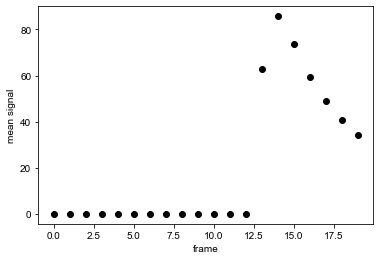

In [6]:
plt.xlabel('frame')
plt.ylabel('mean signal')
plt.plot(np.mean(video[0:20], axis = (1,2)), "ko")

In [7]:
video.shape

(176, 608, 968)

1.0973597359735974


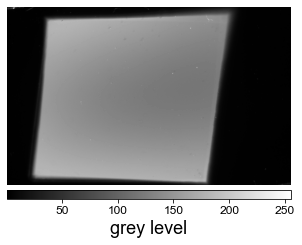

In [8]:


ref = 14#click.prompt("First useful frame", type=int, default=0)

p.set_figure()
plt.axis("off")
image = plt.imshow(video[ref], cmap = "gray")

H, L = video[ref].shape
#rec = matplotlib.patches.Rectangle((H-5*H//6, L-4*L//7), H//6*4.8, L//100, color = "lightgrey")
ratio = 3.5/(H//6*4.8)
scale = H//4
rec = matplotlib.patches.Rectangle((H-H//5, L-L//9), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel("grey level", size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)

plt.savefig(p.save_folder + "/" + filename + "_intensity" + p.extension)

print(ratio*scale)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


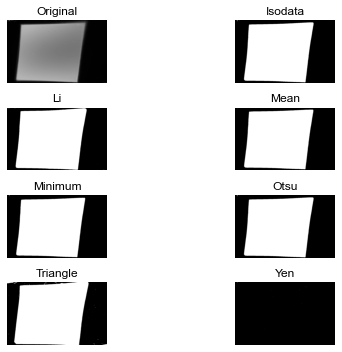

In [9]:
u = skimage.filters.try_all_threshold(video[ref])


In [11]:
threshold_method = threshold_convert("triangle")

#click.prompt("copy the name of the thresholding method that suits you. If none suits, enter None", type = str, default="skimage.filters.thresholding.threshold_minimum"))


triangle


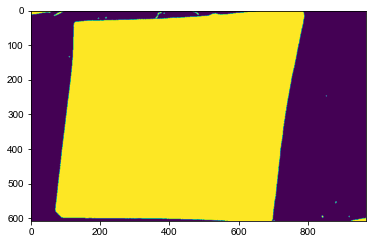

In [12]:
D = 1# click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)

video = np.array(video)
timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
mask = downscale_local_mean(video[ref], (D,D))
threshold = threshold_method(mask)

mask = mask>threshold
mask = skimage.morphology.binary_opening(mask)
#mask[:, 0:15] = 0

plt.imshow(mask)




#downscaling 
video_downscaled = []
for i in range(ref, video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]
video_2D = np.copy(video_downscaled)
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

In [13]:
timing.shape

(176,)

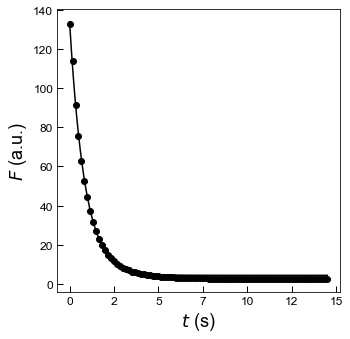

In [14]:
stop = len(video)//2 #<------ you can select a shorter segment for the fits
#fit on the mean value before performing the fit on each pixel
timing = np.linspace(0, stop - 1, stop)/framerate

params = simple_tau(np.mean(to_evaluate[0:stop], axis = 1), timing[0:stop], sample_rate = framerate)

fig = p.set_figure("%d", "%d")
time = timing[0:stop]
time -= time[0]
plt.plot(time, np.mean(to_evaluate[0:stop], axis = 1), "ok", label = "raw data")

x2 = np.linspace(time.min(), time.max(), 1024)
plt.plot(x2, exp_decay(params, x2), "k", label = "fit")

plt.xlabel('$t$ (s)')
plt.ylabel("$F$ (a.u.)")
#plt.legend()
plt.savefig(p.save_folder + filename + "_mean_decay_fit_D2.pdf")

In [93]:
sat = np.sum(to_evaluate[ref]==255)/len(to_evaluate[ref].flatten())*100
print("percent of saturated pixels in the mask: ", sat)

if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")

percent of saturated pixels in the mask:  0.0


In [94]:
#parallel fit on each pixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[0:stop,i], timing[0:stop], sample_rate = framerate) for i in tqdm(range(to_evaluate.shape[1])))


100%|████████████████████████████████████████████████████████████████████████| 375116/375116 [01:54<00:00, 3275.93it/s]


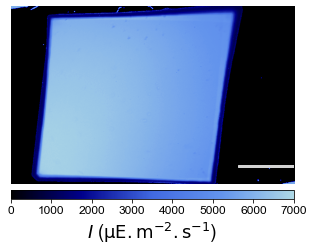

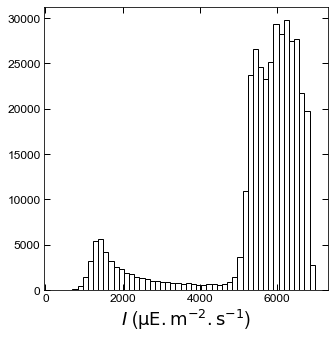

In [95]:
tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480


I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480
I_480_map[I_480_map<0]  = 0


np.save("../images/I_480_map.npy", I_480_map)

plt.rcParams['image.cmap'] = 'viridis'


 
I, dis, fig = plot_map(I_480, I_480_map,filename + "_I_480_map_B" + p.extension, limits = (0, 7000))

np.save("../images/video_2D.npy", video_2D)
np.save("../images/framerate.npy", framerate)


## Ian exp

In [96]:
folder = "../data/macroimager/macro_ian/"

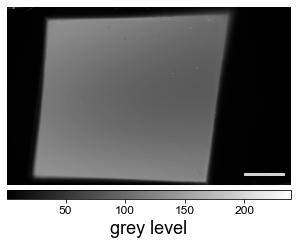

In [97]:
filename = "MacroIllumination_FirstImageInDecay_Greyscale"
data0 = np.load(folder + filename + ".npy")

p.set_figure()
plt.axis("off")
image = plt.imshow(data0, cmap = "gray")

L, H = data0.shape
#rec = matplotlib.patches.Rectangle((H-5*H//6, L-4*L//7), H//6*4.8, L//100, color = "lightgrey")
ratio = 3.5/(H//6*4.8)
scale = H//7
rec = matplotlib.patches.Rectangle((H-H//6, L-L//15), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel("grey level", size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)

plt.savefig(p.save_folder + "/" + filename + p.extension)

(array([2.54058e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 7.50000e+01, 8.43000e+02, 8.52000e+02, 7.73000e+02,
        7.29000e+02, 7.24000e+02, 6.90000e+02, 7.18000e+02, 6.28000e+02,
        6.80000e+02, 7.03000e+02, 7.22000e+02, 6.96000e+02, 9.15000e+02,
        1.16800e+03, 2.88400e+03, 8.85100e+03, 2.13540e+04, 2.77600e+04,
        2.56630e+04, 2.35210e+04, 2.52100e+04, 2.98570e+04, 2.86360e+04,
        3.05360e+04, 2.81480e+04, 2.80960e+04, 2.19680e+04, 2.10860e+04]),
 array([   0.        ,  136.94059215,  273.88118431,  410.82177646,
         547.76236862,  684.70296077,  821.64355292,  958.58414508,
        1095.52473723, 1232.46532938, 1369.40592154, 1506.34651369,
        1643.28710585, 1780.227698  , 1917.16829015, 2054.108882

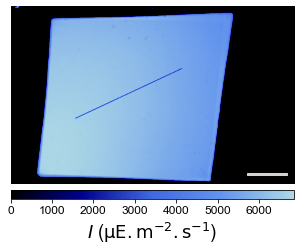

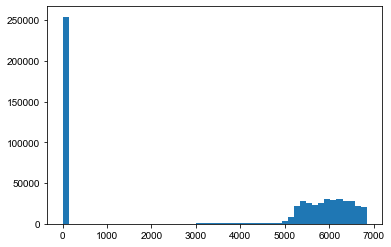

In [98]:
filename = "MacroIllumination_ExperimentalIntensityMap"
data0 = np.load(folder + filename + ".npy")

p.set_figure()
plt.axis("off")
image = plt.imshow(data0, cmap = blue_map)

L, H = data0.shape
#rec = matplotlib.patches.Rectangle((H-5*H//6, L-4*L//7), H//6*4.8, L//100, color = "lightgrey")
ratio = 3.5/(H//6*4.8)
scale = H//7
rec = matplotlib.patches.Rectangle((H-H//6, L-L//15), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel(p.label_intensity, size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)

plt.savefig(p.save_folder + "/" + filename + p.extension)


plt.figure()
plt.hist(data0.flatten(), bins = 50)

In [99]:
data0.shape

(608, 968)

(array([  589.,   637.,   486.,   503.,   557.,   563.,   513.,   505.,
          485.,   534.,   571.,   555.,   622.,   710.,   780.,   762.,
         1222.,  1931.,  2489.,  3520.,  4442.,  6031.,  7505.,  9763.,
        11064., 12479., 13150., 14070., 14264., 14858., 14620., 15255.,
        15919., 16570., 15753., 15975., 15781., 15646., 15149., 14145.,
        13012., 11496.,  9371.,  7305.,  4723.,  3157.,  1907.,  1080.,
          518.,   350.]),
 array([3000.2349062 , 3080.23020808, 3160.22550996, 3240.22081183,
        3320.21611371, 3400.21141558, 3480.20671746, 3560.20201934,
        3640.19732121, 3720.19262309, 3800.18792496, 3880.18322684,
        3960.17852872, 4040.17383059, 4120.16913247, 4200.16443434,
        4280.15973622, 4360.1550381 , 4440.15033997, 4520.14564185,
        4600.14094372, 4680.1362456 , 4760.13154747, 4840.12684935,
        4920.12215123, 5000.1174531 , 5080.11275498, 5160.10805685,
        5240.10335873, 5320.09866061, 5400.09396248, 5480.08926436

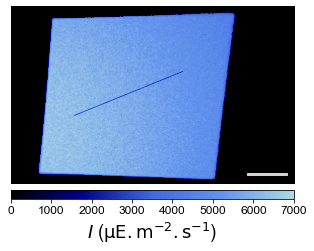

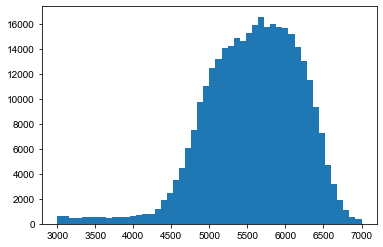

In [134]:
filename = "MacroIllumination_SimulatedIntensityMap"
data0 = np.load(folder + filename + ".npy")
data0[data0>7000]=7000

p.set_figure()
plt.axis("off")
image = plt.imshow(data0, cmap = blue_map)

L, H = data0.shape
#rec = matplotlib.patches.Rectangle((H-5*H//6, L-4*L//7), H//6*4.8, L//100, color = "lightgrey")
ratio = 3.5/(H//6*4.8)
scale = H//7
rec = matplotlib.patches.Rectangle((H-H//6, L-L//15), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel(p.label_intensity, size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)

plt.savefig(p.save_folder + "/" + filename + p.extension)

plt.figure()
plt.hist(data0[data0!=0].flatten(), bins = 50)

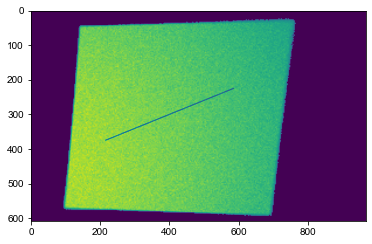

In [101]:
data = np.load("../data/macroimager/macro_ian/MacroIllumination_SimulatedIntensityMap.npy")
plt.imshow(data)

(array([2.0000e+00, 4.0000e+00, 3.7000e+01, 1.6000e+02, 5.3600e+02,
        1.5370e+03, 3.3750e+03, 5.5710e+03, 5.6390e+03, 4.1630e+03,
        3.1970e+03, 2.5530e+03, 2.2800e+03, 1.9150e+03, 1.7200e+03,
        1.4730e+03, 1.3330e+03, 1.2380e+03, 1.0700e+03, 1.0090e+03,
        9.6200e+02, 8.9300e+02, 7.9000e+02, 7.7000e+02, 7.3800e+02,
        7.2700e+02, 6.6100e+02, 5.5100e+02, 6.6300e+02, 6.4600e+02,
        6.6000e+02, 6.2500e+02, 8.3700e+02, 9.6900e+02, 2.0220e+03,
        5.9130e+03, 1.5533e+04, 2.8068e+04, 2.5646e+04, 2.3275e+04,
        2.5259e+04, 2.7158e+04, 2.9684e+04, 2.9251e+04, 2.8995e+04,
        2.7969e+04, 2.5426e+04, 2.1060e+04, 1.0425e+04, 1.2800e+02]),
 array([ 299.1565709 ,  434.03258571,  568.90860052,  703.78461532,
         838.66063013,  973.53664493, 1108.41265974, 1243.28867454,
        1378.16468935, 1513.04070415, 1647.91671896, 1782.79273376,
        1917.66874857, 2052.54476337, 2187.42077818, 2322.29679298,
        2457.17280779, 2592.04882259, 2726.924

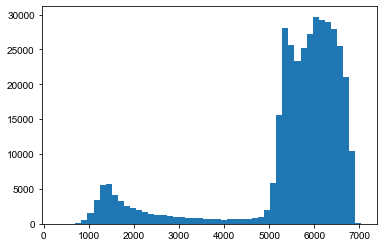

In [102]:
plt.hist(I_480, bins=50)

(array([  589.,   637.,   486.,   503.,   557.,   563.,   513.,   505.,
          485.,   534.,   571.,   555.,   622.,   710.,   780.,   762.,
         1222.,  1931.,  2489.,  3520.,  4442.,  6031.,  7505.,  9763.,
        11064., 12479., 13150., 14070., 14264., 14858., 14620., 15255.,
        15919., 16570., 15753., 15975., 15781., 15646., 15149., 14145.,
        13012., 11496.,  9371.,  7305.,  4723.,  3157.,  1907.,  1080.,
          518.,   350.]),
 array([3000.2349062 , 3080.23020808, 3160.22550996, 3240.22081183,
        3320.21611371, 3400.21141558, 3480.20671746, 3560.20201934,
        3640.19732121, 3720.19262309, 3800.18792496, 3880.18322684,
        3960.17852872, 4040.17383059, 4120.16913247, 4200.16443434,
        4280.15973622, 4360.1550381 , 4440.15033997, 4520.14564185,
        4600.14094372, 4680.1362456 , 4760.13154747, 4840.12684935,
        4920.12215123, 5000.1174531 , 5080.11275498, 5160.10805685,
        5240.10335873, 5320.09866061, 5400.09396248, 5480.08926436

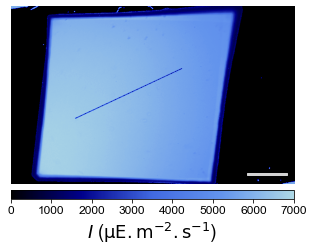

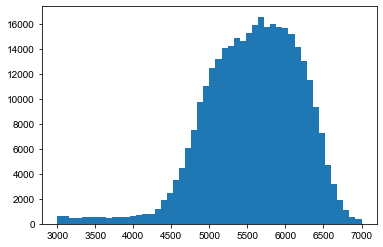

In [112]:
line = np.load("../data/macroimager/macro_ian/MacroIllumination_ExperimentalIntensityMap_line.npy")
mask_line = line>0

p.set_figure()
plt.axis("off")
im_line = np.copy(I_480_map)
im_line[mask_line] = np.min(im_line)
image = plt.imshow(im_line, cmap = blue_map)

L, H = I_480_map.shape
#rec = matplotlib.patches.Rectangle((H-5*H//6, L-4*L//7), H//6*4.8, L//100, color = "lightgrey")
ratio = 3.5/(H//6*4.8)
scale = H//7
rec = matplotlib.patches.Rectangle((H-H//6, L-L//15), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)

divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel(p.label_intensity, size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)

plt.savefig(p.save_folder + "/" + "experience_angle" + p.extension)

plt.figure()
plt.hist(data0[data0!=0].flatten(), bins = 50)

## Simulation decay

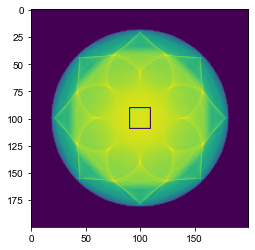

In [149]:
data = np.load("../data/macroimager/macro_ian/LEDArray_ROI_DecayCurve_Image.npy")
plt.imshow(data)

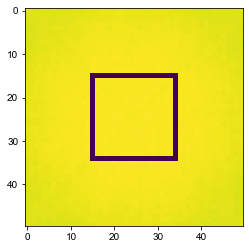

In [116]:
plt.imshow(data[75:125, 75:125])

In [187]:
x= np.load("../data/macroimager/macro_ian/LEDArray_ROI_DecayCurve_X_Values.npy")
y= np.load("../data/macroimager/macro_ian/LEDArray_ROI_DecayCurve_Y_Values.npy")
len(x)

500

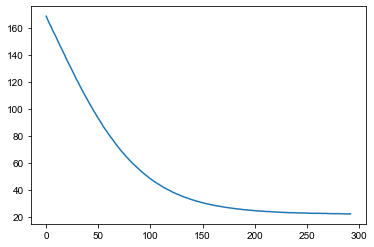

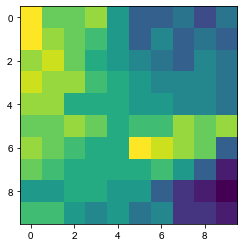

In [214]:
filename = "../data/macroimager/macro_ian/video_LED_RadialArray.tiff"
video = tiff.imread(filename)

#plt.plot(np.mean(video[, axis = (1,2)))
video = video[:, 30:560, 170:700]
val = 530
u = np.copy(video)
k = 2
KK = 100
M = val//3
delta = val//KK
u = u[:, M - delta   + k: M + delta + k, M - delta  + k : M + delta  + k]
y2 = np.mean(u, axis = (1,2))[7:300]

plt.plot(y2)
#plt.plot(np.mean(video, axis = (1,2)))
x3 = np.linspace(0, 300, len(y2))
params2 = simple_tau(y2, x3, sample_rate = 1)
plt.figure()
plt.imshow(u[10])

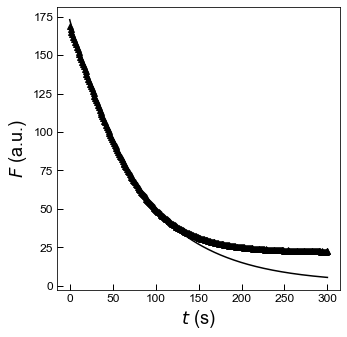

In [215]:

fr = len(x)/(x[-1]-x[0])
params = simple_tau(y, x, sample_rate = fr)
x3 = np.linspace(0, 300, len(y2))
params2 = simple_tau(y2, x3, sample_rate = 1)

fig = p.set_figure("%d", "%d")
time = x
time -= time[0]
#plt.plot(time, y, "ok", label = "raw data")
plt.plot(x3, y2, "^k", label = "raw data")

x2 = np.linspace(time.min(), time.max(), 1024)
#plt.plot(x2, exp_decay(params, x2), "k", label = "fit")

plt.plot(x3, exp_decay(params2, x3), "k", label = "fit")

plt.xlabel('$t$ (s)')
plt.ylabel("$F$ (a.u.)")
#plt.legend()
plt.savefig(p.save_folder + "ian_mean_decay_fit_D2.pdf")

In [130]:
u = I_480_map==I_480_map.min()

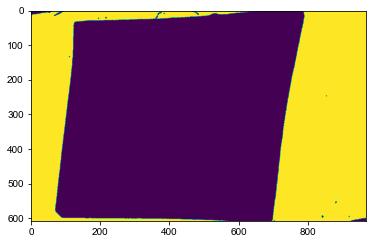

In [133]:
plt.imshow(u)

In [129]:
np.sum(u)

1